# LSDL CUB, Homework 3. Constrastive Learning [10 pts]

This task is dedicated to contrastive self-supervised methods. We will focus on the SimCLR and BYOL algorithms that were discussed in class. We will conduct experiments on the [STL10](https://cs.stanford.edu/~acoates/stl10/) dataset, which is ideal for pretraining without labels, as it contains 100k unlabeled, 5k training labeled and 8k test labeled images.

To submit the task, you must conduct the experiments described in this notebook and write a report on them in PDF format. Along with the report, the code that allows you to run the experiments must be submitted. Before implementing anything, read all the experiment statements and think about how to better organize the code, do not forget to checkpoint the necessary trained models. We reserve the right to lower the grade for poorly structured code. Be sure to use the **training optimizations** from the [list](https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html) in your pipelines, for example, Automatic Mixed Precision, to speed up the experiments. Also note that the report is a **mandatory part** of the assessment, without it we will not check your assignment. The report must include training curves for all the models you run. Also, make sure that your figures and graphs are readable.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys

sys.path.append('..')

In [4]:
from omegaconf import DictConfig, OmegaConf

OmegaConf.register_new_resolver("eval", eval)

**All code and results can be found in [wandb report](https://wandb.ai/makartkar/constrastive_learning_lsdl_hw3/reports/Contrastive-learning--VmlldzoxMDEwMDg2MA)**

## 0. Supervised baseline [0 pts]

**If not completed, the maximum for the entire task is 0 points**

We will start our study by training a supervised model from a random initial approximation. Use the labeled train for training, and the labeled test for testing. We will use ResNet-18\* as the neural network architecture. We recommend searching for hyperparameters and augmentations for training on STL-10 in articles. The author of the task got an accuracy of about 71-72%.

\**For datasets with a smaller image size than ImageNet (such as CIFAR-10/100, STL-10), it is common to use ResNet-18 with modified first layers: usually, 7x7 convolution is replaced with 3x3, and 2x2 MaxPooling is removed. We suggest you train the regular ResNet-18 in the torchvision implementation to save time.*

In [4]:
# YOUR SOLUTION HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

## 1. SimCLR [1.5 pts]

Implement and train the SimCLR method from [Chen et al, 2020](https://arxiv.org/pdf/2002.05709.pdf). We want you to implement it yourself, so this task does not allow you to borrow code from open sources. Use the unlabeled part of STL-10 as a training set, and use the labeled train to validate the algorithm.

In [5]:
# YOUR SOLUTION HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

## 2. BYOL [2.5 pts]

Similar to the previous task, implement and train the BYOL method from [Grill et al, 2020](https://arxiv.org/pdf/2006.07733.pdf). To check that the projections do not collapse (the variable $z$ from the original paper), plot the standard deviation of $z$ throughout training.

In [6]:
# YOUR SOLUTION HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

## 3. t-SNE [1.5 pts]

Using the t-SNE method, visualize the embeddings of images from the training and test samples that are obtained from supervised, SimCLR and BYOL models. The output of the average pooling of the model is taken as embeddings. The points corresponding to each of the 10 classes should be plotted with the same color.

In [5]:
import hydra
import matplotlib.pyplot as plt
import numpy as np
import torch
from copy import deepcopy
from hydra import compose, initialize
from sklearn.manifold import TSNE
from tqdm import tqdm

In [6]:
def prepare_datamodule(exp, data_dir_name):
    with initialize(version_base=None, config_path="../configs"):
        cfg_data = compose(config_name="train", overrides=[f"experiment={exp}", f"data.data_dir=../data/{data_dir_name}"])
    data = hydra.utils.instantiate(cfg_data.data)
    data.setup()
    return data

In [17]:
import glob

def get_model(run, overrides):
    with initialize(version_base=None, config_path="../configs"):
        cfg = compose(config_name="train", overrides=[f"experiment={run['exp_name']}", *overrides])
    model = hydra.utils.instantiate(cfg.model)
    ckpt_path = glob.glob(run['ckpt_path'])[0]
    model.load_state_dict(torch.load(ckpt_path, weights_only=False)['state_dict'])
    return model


def process_dataloader(net, dataloader, data):
    all_feats, all_labels = [], []
    for batch in tqdm(data.train_dataloader()):
        imgs, labels = batch
        feats = net(imgs.cuda())
        all_feats.extend(feats.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())
    feats = np.array(all_feats)
    labels = np.array(all_labels, dtype=np.int8)
    return feats, labels


def plot_tsne(embeddings_2d, labels, key, fig, ax):
    scatter = ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap="tab10", alpha=0.7)
    fig.colorbar(scatter, ticks=range(len(np.unique(labels))))
    ax.title.set_text(f"t-SNE of Image Representations: {key}")

def tsne(data, runs):
    fig, ax = plt.subplots(2, len(runs))
    fig.set_size_inches(18.5, 10.5)
    fig.tight_layout()

    for i, run in enumerate(runs):
        model = get_model(run, run.get('overrides', []))
        net = model.net.encoder
        net.cuda()

        for j, (key, dataloader) in enumerate(zip(('train', 'test'), (data.train_dataloader(), data.test_dataloader()))):
            feats, labels = process_dataloader(net, dataloader, data)
            tsne = TSNE(n_components=2, perplexity=30, random_state=0)
            embeddings_2d = tsne.fit_transform(feats)
            plot_tsne(embeddings_2d, labels, f"{run['exp_name']}-{key}", fig, ax[j, i])
    plt.show()

In [8]:
stl10_runs = [
    {
        'exp_name': 'stl10_baseline',
        'ckpt_path': '../logs/report/runs/stl10_baseline/checkpoints/epoch*.ckpt',
    },
    {
        'exp_name': 'sim_clr',
        'ckpt_path': '../logs/report/runs/sim_clr/checkpoints/epoch*.ckpt',
    },
    {
        'exp_name': 'byol',
        'ckpt_path': '../logs/report/runs/byol/checkpoints/epoch*.ckpt',
    },
]

In [9]:
stl10_data = prepare_datamodule('stl10_baseline', 'stl10')

/home/coder/.local/lib/rolos-python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/coder/.local/lib/rolos-python/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/home/coder/.local/lib/rolos-python/site-packages/hydra/_internal/instantiate/_instantiate2.py:92: UserWarning: Argument 'min_heigth' is not valid and will be ignored.
  return _target_(*args, **kwargs)


/home/coder/.local/lib/rolos-python/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'criterion' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['criterion'])`.
/home/coder/tmp/ipykernel_67274/2875222143.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We reco

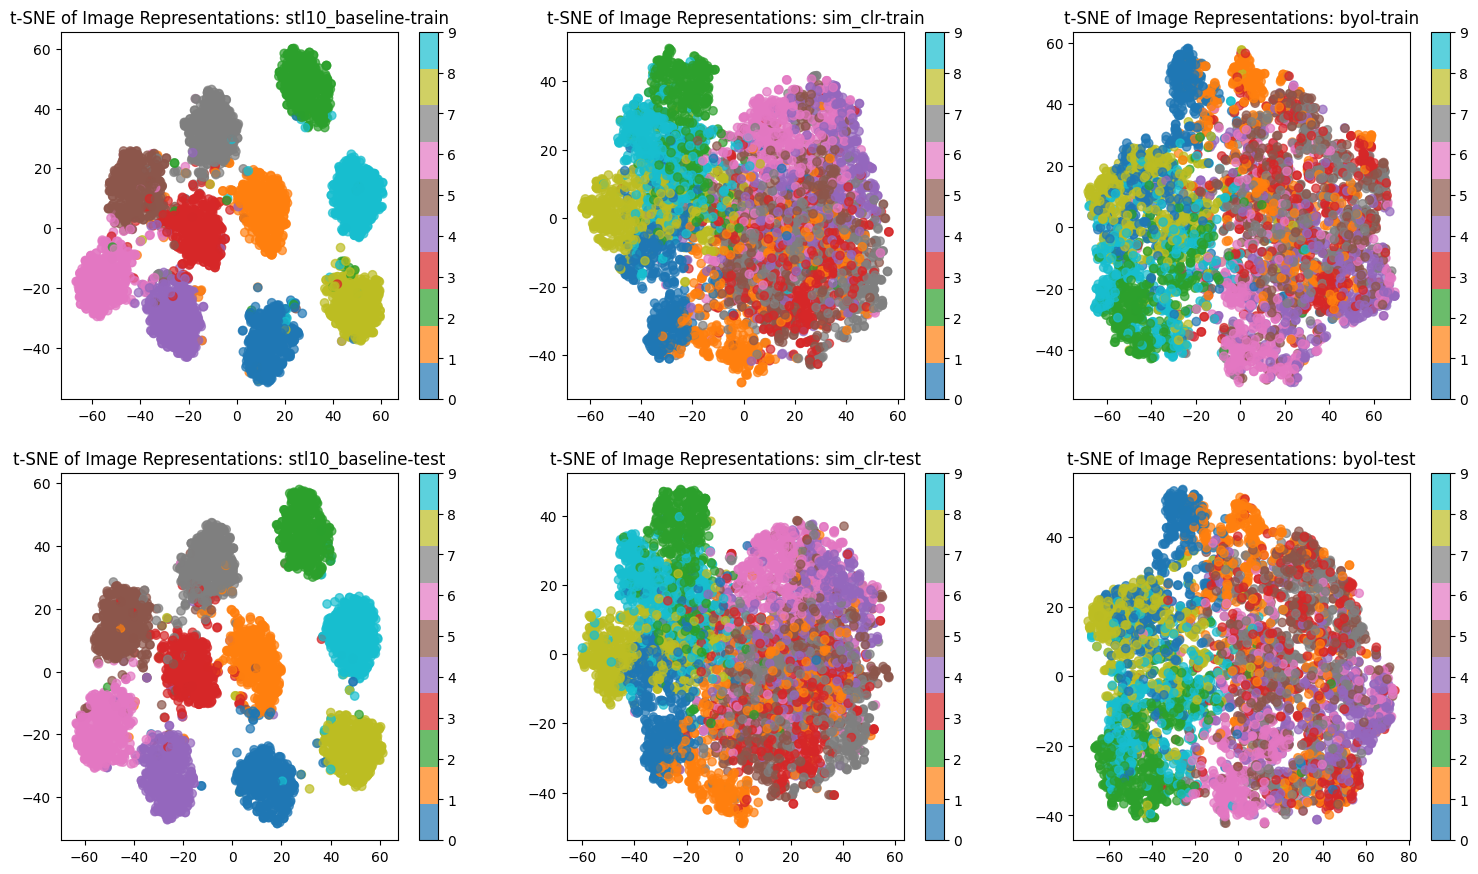

In [15]:
tsne(stl10_data, stl10_runs)

## 4. Linear probing [1 pts]

Train a linear probe for self-supervised models, compare the quality with supervised training.

In [ ]:
# YOUR SOLUTION HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

## 5. Fine-tuning [1.5 pts]

Finally, fine-tune the self-supervised models to STL-10 classification. If you did everything correctly, the quality should be several percent higher than that of the baseline. Similar to task 3, draw how the embeddings changed after the fine-tuning process.

In [19]:
fine_tuned_stl10_runs = [
    {
        'exp_name': 'stl10_baseline',
        'ckpt_path': '../logs/report/runs/stl10_baseline/checkpoints/epoch*.ckpt',
    },
    {
        'exp_name': 'fine_tune',
        'ckpt_path': '../logs/report/runs/fine_tune_sim_clr_stl10/checkpoints/epoch*.ckpt',
        'overrides': ['model=stl10', 'data=stl10', 'num_classes=10', 'pretrained_experiment=sim_clr_gpu_transforms']
    },
    {
        'exp_name': 'fine_tune',
        'ckpt_path': '../logs/report/runs/fine_tune_byol_stl10/checkpoints/epoch*.ckpt',
        'overrides': ['model=stl10', 'data=stl10', 'num_classes=10', 'pretrained_experiment=byol'],
    },
]

/home/coder/.local/lib/rolos-python/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'criterion' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['criterion'])`.
100%|██████████| 36/36 [00:02<00:00, 16.16it/s]
/home/coder/.local/lib/rolos-python/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'criterion' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['criterion'])`.
100%|██████████| 36/36 [00:02<00:00, 14.96it/s]
/home/coder/.local/lib/rolos-python/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'criterion' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['criterion'])`.
100%|██████████| 36/36 [00:02<00:00, 14.09it/s]


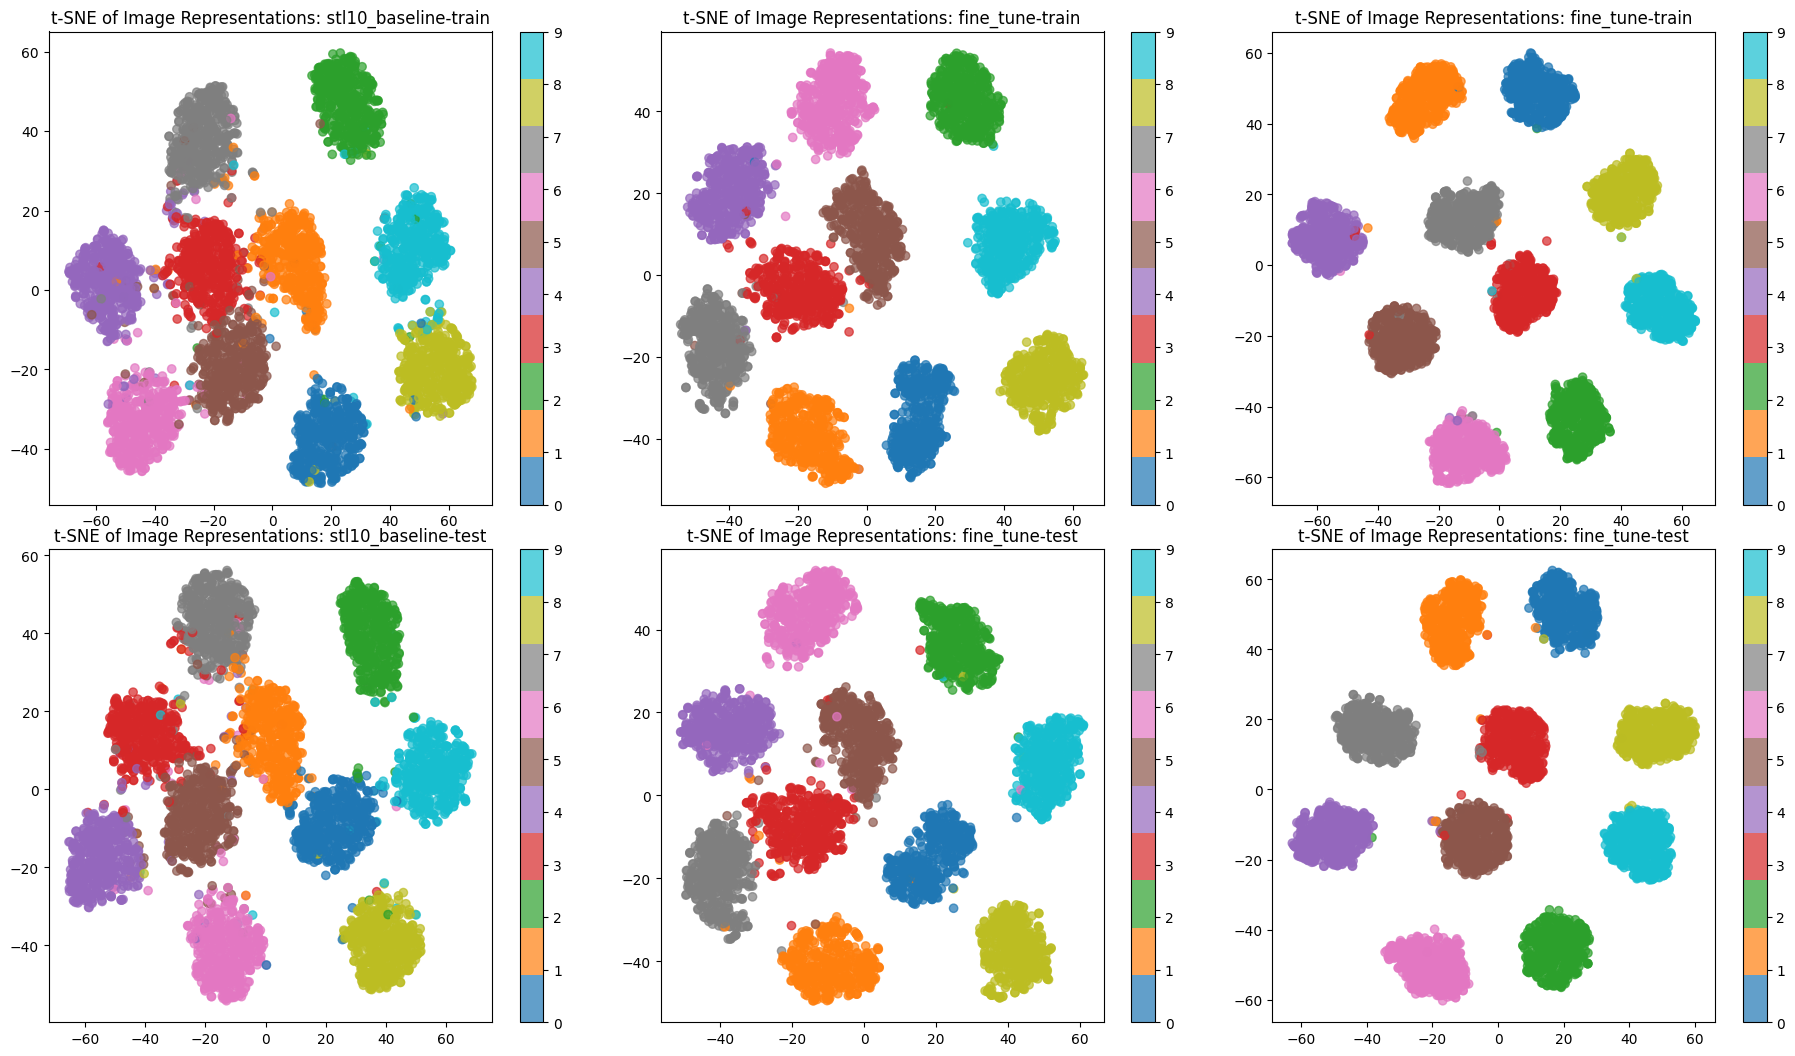

In [20]:
tsne(stl10_data, fine_tuned_stl10_runs)

## 6. OOD robustness [2 pts]

Now, we have 5 different models:

- Supervised
- SimCLR + linear probing
- SimCLR + fine-tuning
- BYOL + linear probing
- BYOL + fine-tuning

We will compare the models by robustness on out-of-distribution objects. As an OOD dataset, we will take the CIFAR-10 test sample, which has almost the same classes as STL-10 (9/10 classes).
The only mismatch in CIFAR-10 is the "frog" class, so drop the images of this class. Compare the trained models by OOD accuracy.

In [24]:
fine_tuned_cifar10_runs = [
    {
        'exp_name': 'cifar10_baseline',
        'ckpt_path': '../logs/report/runs/cifar10_baseline/checkpoints/epoch*.ckpt',
    },
    {
        'exp_name': 'fine_tune',
        'ckpt_path': '../logs/report/runs/fine_tune_sim_clr_cifar10/checkpoints/epoch*.ckpt',
        'overrides': ['model=stl10', 'data=cifar10', 'num_classes=9', 'pretrained_experiment=sim_clr_gpu_transforms']
    },
    {
        'exp_name': 'fine_tune',
        'ckpt_path': '../logs/report/runs/fine_tune_byol_cifar10/checkpoints/epoch*.ckpt',
        'overrides': ['model=stl10', 'data=cifar10', 'num_classes=9', 'pretrained_experiment=byol'],
    },
]

In [22]:
cifar10_data = prepare_datamodule('cifar10_baseline', 'cifar10')

/home/coder/.local/lib/rolos-python/site-packages/hydra/_internal/instantiate/_instantiate2.py:92: UserWarning: Argument 'min_heigth' is not valid and will be ignored.
  return _target_(*args, **kwargs)


/home/coder/.local/lib/rolos-python/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'criterion' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['criterion'])`.
100%|██████████| 317/317 [00:14<00:00, 22.62it/s]
/home/coder/.local/lib/rolos-python/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'criterion' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['criterion'])`.
100%|██████████| 317/317 [00:13<00:00, 23.29it/s]
/home/coder/.local/lib/rolos-python/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'criterion' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['criterion'])`.
100%|██████████| 317/317 [00:13<00:00, 22.76it/s] 


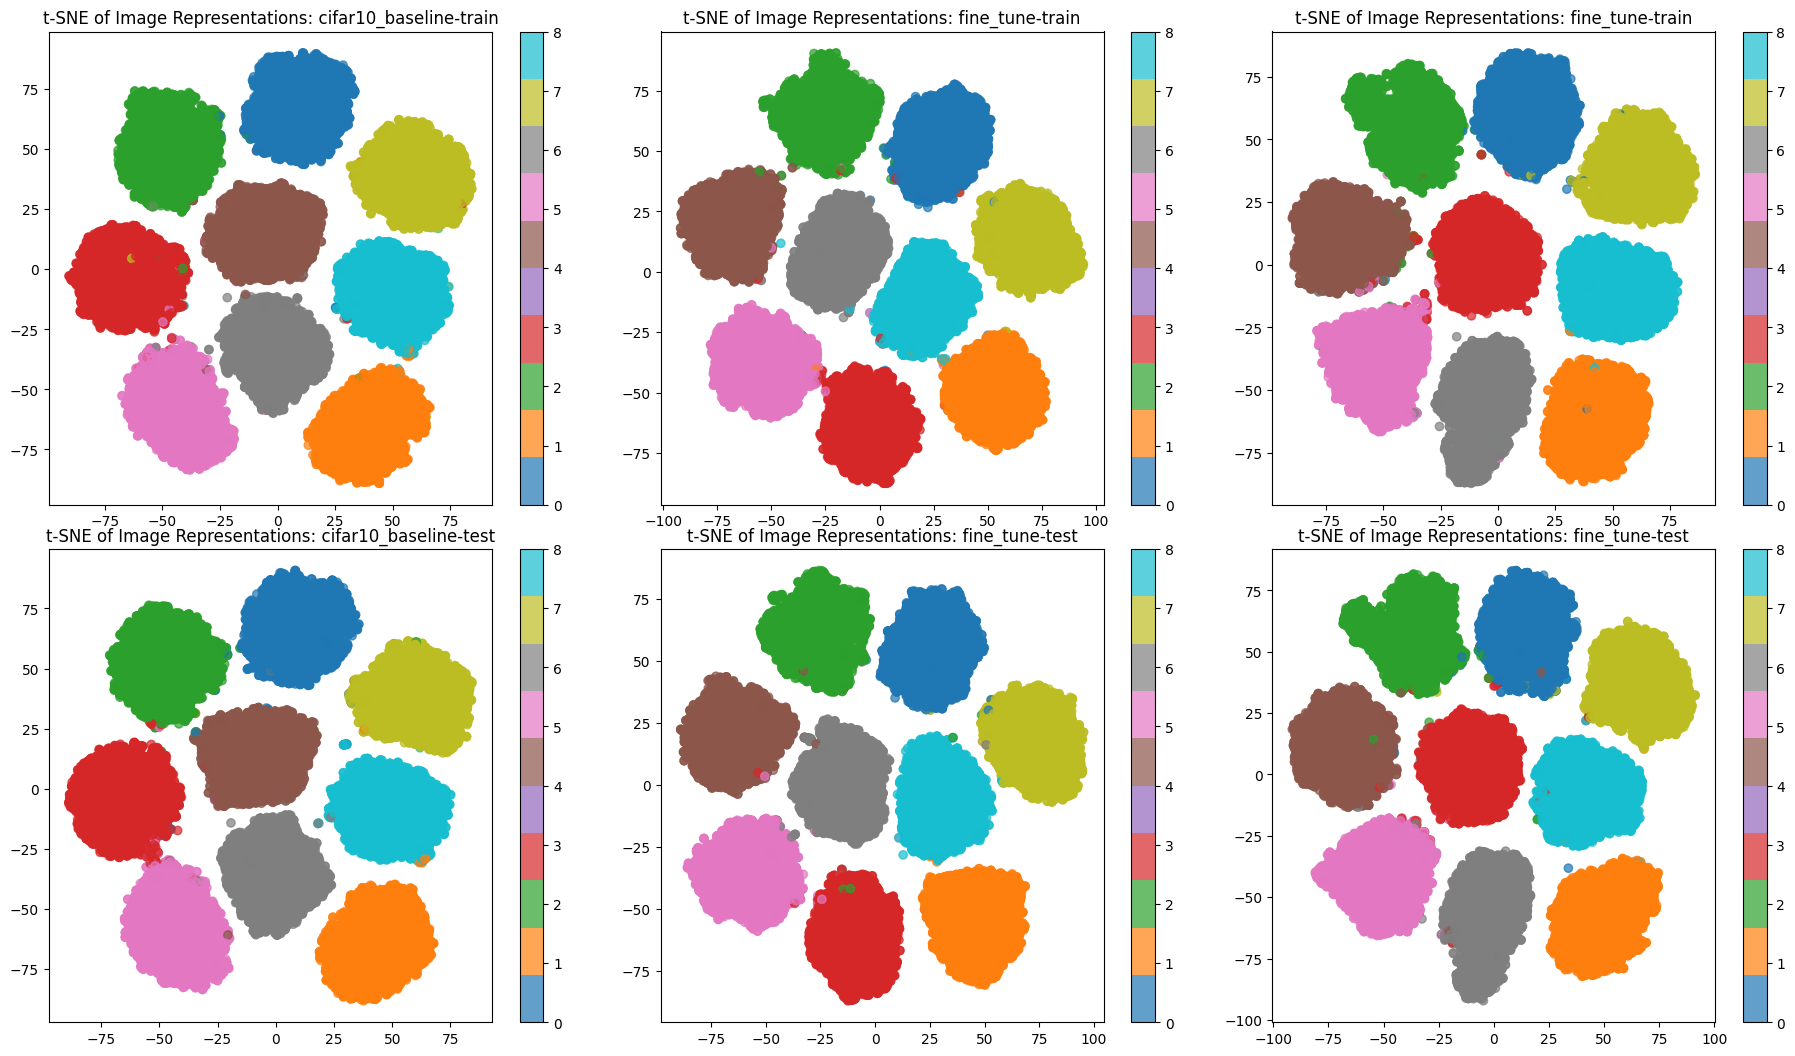

In [25]:
tsne(cifar10_data, fine_tuned_cifar10_runs)

## Bonus. MoCo [2 pts]

As a bonus, let's look at another contrastive self-supervised model, MoCov2, from [He et al, 2019](https://arxiv.org/pdf/1911.05722), [He et al, 2020](https://arxiv.org/pdf/2003.04297.pdf). Conduct all the experiments described above with this model.

In [ ]:
# YOUR SOLUTION HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿